# Tech Challenge - Fase 2 - Machine Learning and Time Series

## Cenário

Na Fase 2 do Tech Challenge, foi proposto um case utilizando dados do índice Ibovespa. O objetivo era desenvolver um modelo preditivo capaz de indicar se o índice irá fechar em alta ou em baixa no dia seguinte, com base no seu próprio histórico de cotações e variações.

Com os resultados obtidos, será desenvolvido um dashboard para monitoramento e apoio à tomada de decisão dos investidores internos, facilitando uma visão mais estratégica do comportamento do mercado.


# Índice Ibovespa

O Ibovespa é o principal índice da B3, a Bolsa de Valores do Brasil, e reflete o desempenho das ações das empresas com maior volume de negociação no mercado.

Na prática, ele funciona como uma média ponderada do desempenho das ações mais negociadas nos últimos meses. Quando se diz que o “Ibovespa subiu”, significa que, em média, essas ações se valorizaram, indicando um maior otimismo dos investidores.

# Dicionário de Dados

| Nome da Coluna | Descrição                                                                                  | Tipo de Dado       |
|----------------|---------------------------------------------------------------------------------------------|--------------------|
| Data           | A data da observação, no formato "DD/MM/AAAA".                                              | Texto (`object`)   |
| Ultimo         | O preço de fechamento do Ibovespa no dia.                                                   | Numérico (`float64`) |
| Abertura       | O preço de abertura do Ibovespa no dia.                                                     | Numérico (`float64`) |
| Maxima         | O preço máximo atingido pelo Ibovespa no dia.                                               | Numérico (`float64`) |
| Minima         | O preço mínimo atingido pelo Ibovespa no dia.                                               | Numérico (`float64`) |
| Volume         | O volume de negociações do dia. Valores com sufixos (ex: "B" para bilhões, "M" para milhões). | Texto (`object`)   |
| Variacao       | A variação percentual do Ibovespa no dia.                                                   | Texto (`object`)   |


# Case Final

Criar um modelo que preveja se o fechamento do IBOVESPA do dia seguinte será maior ou menor que o do dia atual, sendo:

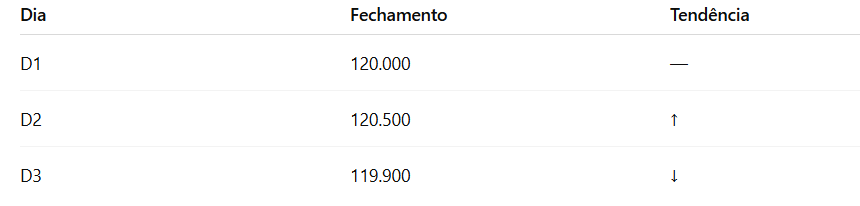

Onde deve prever a tendência (↑ ou ↓) com acuracidade mínima de 75% em um conjunto de teste, esse que contera o último mês (30 dias) de dados disponíveis.

# **Importação das Bibliotecas**


*   Importante instalar a biblioteca "ta" no ambiente que irá executar




In [ ]:
# !pip install ta

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import xgboost as xgb


from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from ta.trend import SMAIndicator
from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator
from ta.trend import MACD

# **Leitura e Tratamento do Dataset**

*   Considerando o período de 10 anos



In [ ]:
dados = yf.download("^BVSP", period="10y", interval="1d")
dados = dados.dropna().reset_index()
dados = dados[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

/tmp/ipython-input-1015753301.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados = yf.download("^BVSP", period="10y", interval="1d")
[*********************100%***********************]  1 of 1 completed


In [ ]:
dados.head()

Price,Date,Open,High,Low,Close,Volume
Ticker,,^BVSP,^BVSP,^BVSP,^BVSP,^BVSP
0,2015-07-31,49897.0,50895.0,49892.0,50865.0,3142200
1,2015-08-03,50867.0,50867.0,50054.0,50138.0,2613200
2,2015-08-04,50138.0,50574.0,49827.0,50058.0,2670400
3,2015-08-05,50067.0,50853.0,50067.0,50287.0,2662100
4,2015-08-06,50280.0,50534.0,49624.0,50011.0,3640800


In [ ]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2481 entries, 0 to 2480
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   (Date, )         2481 non-null   datetime64[ns]
 1   (Open, ^BVSP)    2481 non-null   float64       
 2   (High, ^BVSP)    2481 non-null   float64       
 3   (Low, ^BVSP)     2481 non-null   float64       
 4   (Close, ^BVSP)   2481 non-null   float64       
 5   (Volume, ^BVSP)  2481 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 116.4 KB


In [ ]:
dados.rename(columns={'Date': 'data', 'Open': 'abertura', 'High': 'maxima', 'Low': 'minima', 'Close': 'fechamento', 'Volume': 'volume'}, inplace=True)
dados.head()

Price,data,abertura,maxima,minima,fechamento,volume
Ticker,,^BVSP,^BVSP,^BVSP,^BVSP,^BVSP
0,2015-07-31,49897.0,50895.0,49892.0,50865.0,3142200
1,2015-08-03,50867.0,50867.0,50054.0,50138.0,2613200
2,2015-08-04,50138.0,50574.0,49827.0,50058.0,2670400
3,2015-08-05,50067.0,50853.0,50067.0,50287.0,2662100
4,2015-08-06,50280.0,50534.0,49624.0,50011.0,3640800


In [ ]:
# Verifica dados nulos
dados.isnull().sum()

,,0
Price,Ticker,
data,,0
abertura,^BVSP,0
maxima,^BVSP,0
minima,^BVSP,0
fechamento,^BVSP,0
volume,^BVSP,0


### **Histograma de Distribuição de Frequência dos Fechamentos**

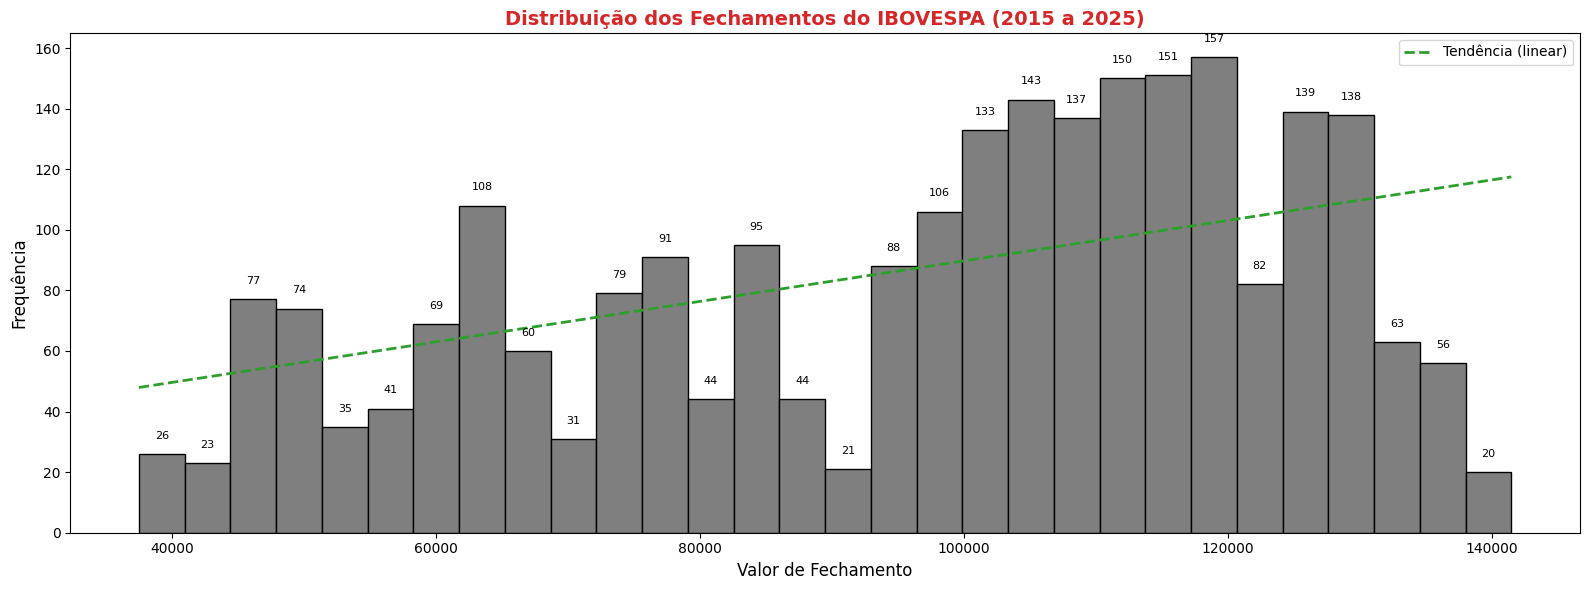

In [ ]:
# Utilizando o gráfico de histograma para identificar a distribuição de fechamento nos últimos 10 anos

plt.figure(figsize=(16, 6))
counts, bins, patches = plt.hist(dados["fechamento"], bins=30, color='tab:gray', edgecolor='black')

for count, bin_left, bin_right in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        plt.text((bin_left + bin_right) / 2, count + 5, f"{int(count)}", ha='center', fontsize=8)

centers = (bins[:-1] + bins[1:]) / 2
m, b = np.polyfit(centers, counts, 1)
x_line = np.linspace(bins[0], bins[-1], 200)
y_line = m * x_line + b
plt.plot(x_line, y_line, linewidth=2, color='tab:green' , linestyle='--' ,label='Tendência (linear)')

plt.xlabel("Valor de Fechamento", fontsize=12)
plt.ylabel("Frequência", fontsize=12)
plt.title("Distribuição dos Fechamentos do IBOVESPA (2015 a 2025)", color='tab:red', fontsize=14, weight='bold')
plt.legend()
plt.tight_layout()
plt.show()

# **Definição das Features e Criação do Target**

In [ ]:
fechamento_series = dados['fechamento'].squeeze()

print(type(dados['fechamento']))
print(dados['fechamento'].shape)

<class 'pandas.core.frame.DataFrame'>
(2481, 1)


In [ ]:
# Features e tendencia (target)

dados['var_dia'] = (dados['fechamento'] - dados['abertura']) / dados['abertura']
dados['MM20'] = dados['fechamento'].rolling(window=20).mean()
dados['sma_5'] = SMAIndicator(close=fechamento_series, window=5).sma_indicator()
dados['sma_10'] = SMAIndicator(close=fechamento_series, window=10).sma_indicator()
dados['rsi_7'] = RSIIndicator(close=fechamento_series, window=7).rsi()


dados['tendencia'] = np.where(dados['fechamento'].shift(-1) < dados['fechamento'], 1, 0)


dados.dropna(inplace=True)

dados = dados.sort_values('data')

dados.head()

Price,data,abertura,maxima,minima,fechamento,volume,var_dia,MM20,sma_5,sma_10,rsi_7,tendencia
Ticker,,^BVSP,^BVSP,^BVSP,^BVSP,^BVSP,,,,,,
19,2015-08-27,46038.0,47997.0,46038.0,47715.0,4252000,0.036426,47926.30,45670.8,46376.7,57.999314,1
20,2015-08-28,47697.0,47872.0,46847.0,47154.0,3778600,-0.011384,47740.75,45957.6,46341.3,52.083473,1
21,2015-08-31,47151.0,47151.0,45570.0,46626.0,4667300,-0.011134,47565.15,46415.6,46282.2,46.837727,1
22,2015-09-01,46625.0,46625.0,45278.0,45477.0,3665000,-0.024622,47336.10,46602.0,46084.8,37.299926,0
23,2015-09-02,45484.0,46474.0,45445.0,46464.0,3740100,0.021546,47144.95,46687.2,46072.4,47.926903,0


### **Criação de Lags**

In [ ]:
qtd_lags = 10
for i in range(1, qtd_lags + 1):
    dados[f"lag_{i}"] = dados["fechamento"].pct_change(i)

# Limpeza dos NaNs
dados.dropna(inplace=True)


In [ ]:
dados.tail()

Price,data,abertura,maxima,minima,fechamento,volume,var_dia,MM20,sma_5,sma_10,...,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
Ticker,,^BVSP,^BVSP,^BVSP,^BVSP,^BVSP,,,,,...,,,,,,,,,,
2476,2025-07-25,133820.0,134204.0,133285.0,133524.0,5560900,-0.002212,136748.75,134180.6,134591.0,...,-0.002122,-0.013622,-0.003820,-0.004793,0.001065,-0.015056,-0.014663,-0.012762,-0.013119,-0.019554
2477,2025-07-28,133538.0,133902.0,131550.0,132129.0,6625600,-0.010551,136412.45,133773.0,134274.0,...,-0.010448,-0.012548,-0.023927,-0.014228,-0.015190,-0.009394,-0.025346,-0.024957,-0.023076,-0.023430
2478,2025-07-29,132130.0,133346.0,132130.0,132726.0,6324800,0.004511,136071.30,133511.0,134021.6,...,0.004518,-0.005976,-0.008086,-0.019517,-0.009773,-0.010740,-0.004918,-0.020942,-0.020552,-0.018662
2479,2025-07-30,132702.0,134368.0,131883.0,133990.0,8655300,0.009706,135818.25,133235.4,133869.5,...,0.009523,0.014085,0.003490,0.001360,-0.010180,-0.000343,-0.001319,0.004558,-0.011618,-0.011224
2480,2025-07-31,133987.0,133987.0,132096.0,133071.0,9196800,-0.006836,135425.40,133088.0,133620.1,...,-0.006859,0.002599,0.007129,-0.003393,-0.005508,-0.016969,-0.007200,-0.008169,-0.002332,-0.018397


## **Gráfico de Linha - Acompanhamento da Média de Fechamento Anual (BVSP)**

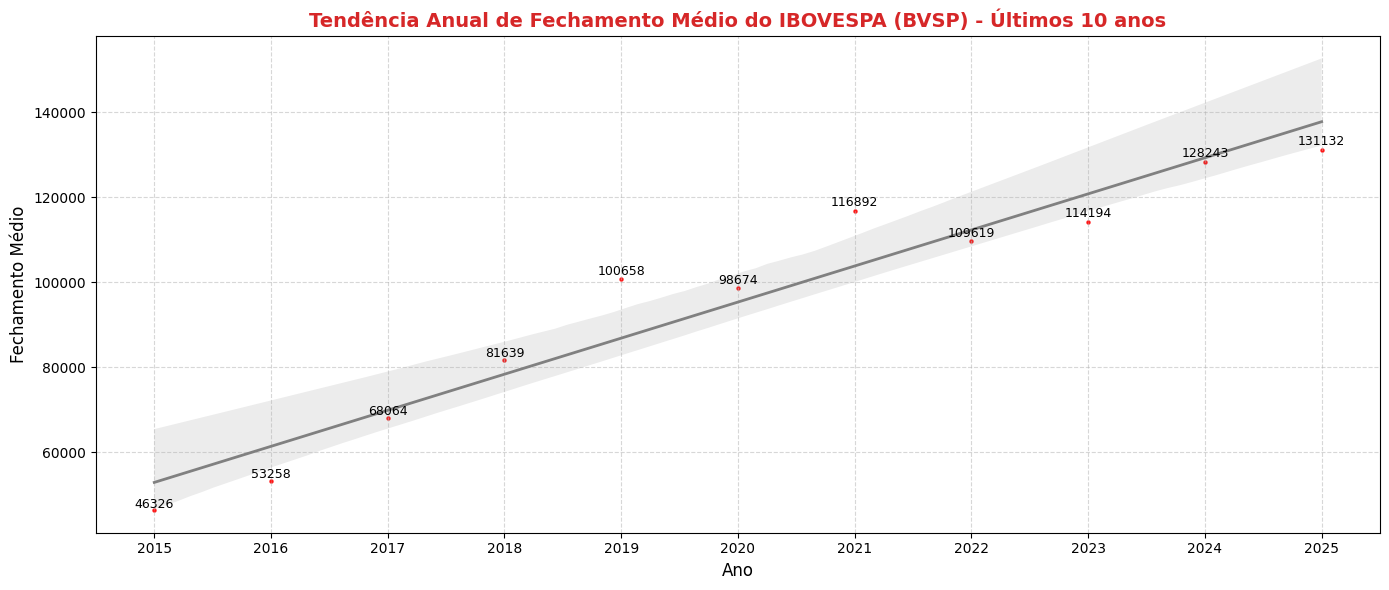

In [ ]:
media_fechamento_por_ano = dados.groupby(dados['data'].dt.year)['fechamento'].mean().reset_index()
media_fechamento_por_ano.columns = ['ano', 'media_fechamento']


plt.figure(figsize=(14, 6))
sns.regplot(data=media_fechamento_por_ano, x='ano', y='media_fechamento', marker='o', color='red', scatter_kws={"s": 5}, line_kws={"color": "gray", "linewidth": 2})

for _, row in media_fechamento_por_ano.iterrows():
    plt.text(row['ano'], row['media_fechamento'] * 1.01, f"{row['media_fechamento']:.0f}", ha='center', fontsize=9)

plt.title('Tendência Anual de Fechamento Médio do IBOVESPA (BVSP) - Últimos 10 anos' , color='tab:red', fontsize=14, weight='bold')
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Fechamento Médio', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(media_fechamento_por_ano['ano'])
plt.tight_layout()
plt.show()

# **Separando Modelos de treino e teste**

In [ ]:
print("Data Mínima:")
display(dados['data'].min())

print("\nData Máxima:")
display(dados['data'].max())

Data Mínima:


Timestamp('2015-09-11 00:00:00')


Data Máxima:


Timestamp('2025-07-31 00:00:00')

In [ ]:
treino = dados[(dados['data'] > "2015-09-01") & (dados['data'] < "2025-06-18")].copy()
teste  = dados[(dados['data'] > "2025-06-17") & (dados['data'] < "2025-07-31")].copy()

features = ['abertura', 'maxima', 'minima', 'var_dia','MM20', 'rsi_7']


x_train = treino[features]
y_train = treino['tendencia']
x_test = teste[features]
y_test = teste['tendencia']

### Validação das linhas consideradas nos modelos de treino e teste

In [ ]:
print("Linhas no teste:", teste.shape[0])
print("\nLinhas no treino:", treino.shape[0])


Linhas no teste: 30

Linhas no treino: 2421


### **Dados Correlações - Features x Target**

In [ ]:
dados_correlacoes = dados[features + ['tendencia']].corr()
print(dados_correlacoes['tendencia'].sort_values())


Price      Ticker
rsi_7                0.003391
abertura   ^BVSP     0.037635
maxima     ^BVSP     0.038064
minima     ^BVSP     0.039195
MM20                 0.040345
var_dia              0.045799
tendencia            1.000000
Name: tendencia, dtype: float64


### **Random Forest**

In [ ]:
modelo_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    random_state=7
)

modelo_rf.fit(x_train, y_train)
y_pred_rf = modelo_rf.predict(x_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
roc_rf = roc_auc_score(y_test, modelo_rf.predict_proba(x_test)[:, 1])

print(f"Acurácia (Random Forest): {acc_rf:.2%}")
print(f"ROC AUC: {roc_rf:.3f}")

Acurácia (Random Forest): 63.33%
ROC AUC: 0.671


### **XGboost**

In [ ]:
modelo_xgb = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
modelo_xgb.fit(x_train, y_train)

y_pred = modelo_xgb.predict(x_test)
acuracia = accuracy_score(y_test, y_pred)
roc_score = roc_auc_score(y_test, modelo_xgb.predict_proba(x_test)[:, 1])

print(f"Acurácia: {acuracia:.2%}")
print(f"ROC AUC: {roc_score:.3f}")

Acurácia: 73.33%
ROC AUC: 0.741


# **Matriz Confusão - Modelo XGboost**

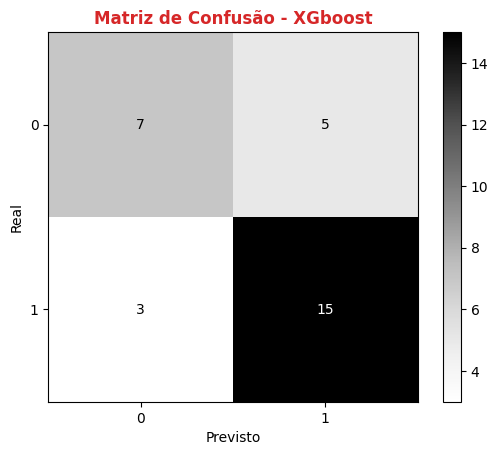

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["0", "1"])
disp.plot(cmap="Grays")
plt.title("Matriz de Confusão - XGboost", color='tab:red', weight='bold')
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

# **Importância das features utilizadas**

In [ ]:
print(classification_report(y_test, y_pred))

importances = modelo_xgb.feature_importances_
importancias_df = pd.DataFrame({'feature': features, 'importance': importances})
importancias_df.sort_values(by='importance', ascending=False, inplace=True)

              precision    recall  f1-score   support

           0       0.70      0.58      0.64        12
           1       0.75      0.83      0.79        18

    accuracy                           0.73        30
   macro avg       0.72      0.71      0.71        30
weighted avg       0.73      0.73      0.73        30



# **Importância das Variáveis**

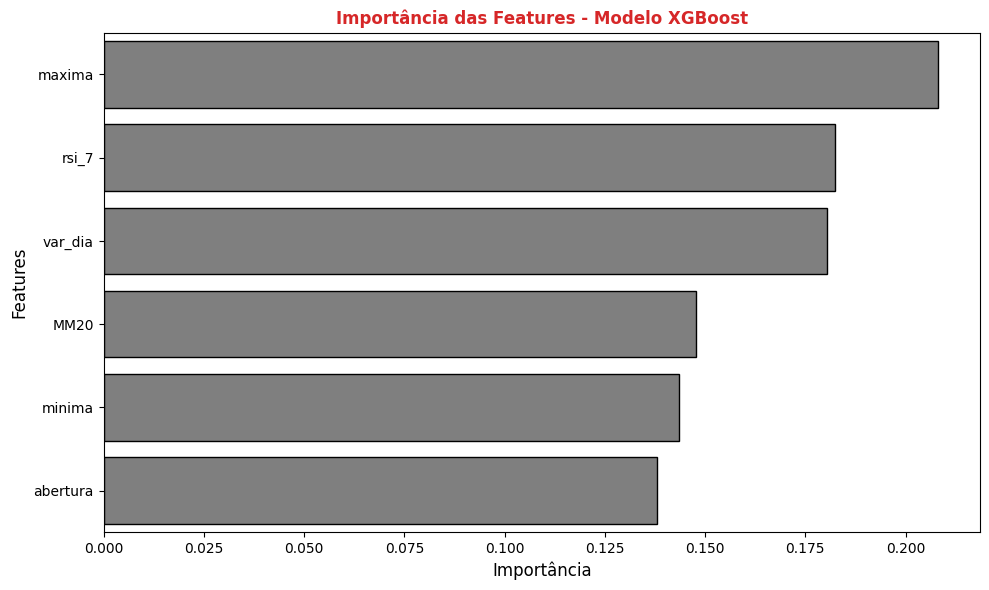

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importancias_df, color='tab:gray', edgecolor='black')
plt.xlabel('Importância', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title("Importância das Features - Modelo XGBoost", color= 'tab:red', weight='bold')
plt.tight_layout()
plt.show()